In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim.optimize import optimize_acqf

from utils import embed_test_function, pick_acqf, pick_kernel, pick_test_function, set_matplotlib_params
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore") # removes negative variances rounding errors and failed fitting attempts


torch.set_default_dtype(torch.double)
set_matplotlib_params()

mpl.rcParams.update(
    {
        "axes.grid": False,
    }
)


# completely arbitrary
def black_box_cost(func, x):
    return 1 + 4 * torch.sin(embed_test_function(func, x)/75)**2


# only works for 2D right now, easy to make N-dim
def discretize(n1, n2):
     xv, yv = torch.meshgrid([torch.linspace(0, 1, n1),
                              torch.linspace(0, 1, n2)])
     X = torch.cat((
     xv.contiguous().view(xv.numel(), 1),
     yv.contiguous().view(yv.numel(), 1)),
     dim=1
     )
     return xv, yv, X


def knn(data, test):
    dist = torch.norm(data - test, dim=1, p=None)
    knn = dist.topk(1, largest=False)
    return knn

In [2]:
seed = 777
exp = "Branin"
ker = "Matern"
acqf = "MES"
B = 80
n_init = int(B / 5)
dim = 2
torch.manual_seed(seed)

problem = pick_test_function(exp)
bounds = torch.tensor(problem._bounds).T
dim = bounds.shape[1]
sigma = 0.01

### INITIALIZE THE COST MODEL
Kcost = pick_kernel(ker, dim)
gpr_cost = SingleTaskGP(torch.empty([0, dim]), torch.empty([0, 1]), covar_module=Kcost)

In [3]:
def initial_design(tau_init, gpr_cost, dim):
    ct = 0
    X_init = torch.empty([0, dim])
    n1, n2 = 20, 20
    while ct < tau_init:
        _, _, X = discretize(n1, n2)
        gpr_cost.eval()
        costs = torch.exp(gpr_cost(X).mean)
        while len(X) > 2:
            maxcost = costs.argmax()
            X = torch.cat((X[:maxcost],X[maxcost+1:]))
            costs = torch.cat((costs[:maxcost],costs[maxcost+1:]))
            if not len(X_init):
                close = int(torch.floor(n1 * n2 * torch.rand(1)))
                X = torch.cat((X[:close],X[close+1:]))
                costs = torch.cat((costs[:close],costs[close+1:]))
            else:
                close = torch.tensor([knn(X_init, x.view(1, -1)).values for x in X]).argmin()
                X = torch.cat((X[:close],X[close+1:]))
                costs = torch.cat((costs[:close],costs[close+1:]))
        # only 2 remaining: keep the cheapest
        X = X[costs.argmin()].view(1, -1)
        X_init = torch.cat((X_init, X))
        ct += 1
        eval_costs = black_box_cost(problem, X_init).view(-1, 1)
        log_costs = torch.log(eval_costs)
        Kcost = pick_kernel(ker, dim)
        gpr_cost = SingleTaskGP(X_init, log_costs, covar_module=Kcost)
        mll_cost = ExactMarginalLogLikelihood(gpr_cost.likelihood, gpr_cost)
        fit_gpytorch_model(mll_cost, max_retries=20);
    return X_init, eval_costs

In [4]:
X_init, costs = initial_design(n_init, gpr_cost, dim)

data = {}
data["train_X"] = X_init
data["costs"] = costs

train_Y = embed_test_function(problem, data["train_X"]).view(-1, 1)
data["train_Y"] = train_Y + sigma * torch.randn(size=train_Y.shape)

K = pick_kernel(ker, dim)
gpr = SingleTaskGP(data["train_X"], data["train_Y"], covar_module=K)
mll = ExactMarginalLogLikelihood(gpr.likelihood, gpr)
fit_gpytorch_model(mll, max_retries=20);

Kcost = pick_kernel(ker, dim)
gpr_cost = SingleTaskGP(data["train_X"], torch.log(data["costs"]), covar_module=Kcost)
mll_cost = ExactMarginalLogLikelihood(gpr_cost.likelihood, gpr_cost)
fit_gpytorch_model(mll_cost, max_retries=20);

In [5]:
n1, n2 = 200, 200
xv, yv, X = discretize(n1, n2)

Y = embed_test_function(problem, X).reshape(n1, n2) 
C = black_box_cost(problem, X).reshape(n1, n2) 

gpr_post_mean = gpr.likelihood(gpr(X)).mean.detach().numpy().reshape(n1, n2)
gpr_post_var = np.sqrt(gpr.likelihood(gpr(X)).variance.detach().numpy()).reshape(n1, n2)

gpr_cost_post_mean = np.exp(gpr_cost.likelihood(gpr_cost(X)).mean.detach().numpy().reshape(n1, n2))
gpr_cost_post_var = np.exp(np.sqrt(gpr_cost.likelihood(gpr_cost(X)).variance.detach().numpy()).reshape(n1, n2))

plot = [Y, gpr_post_mean, gpr_post_var]
plot_cost = [C, gpr_cost_post_mean, gpr_cost_post_var]
plots = [plot, plot_cost]

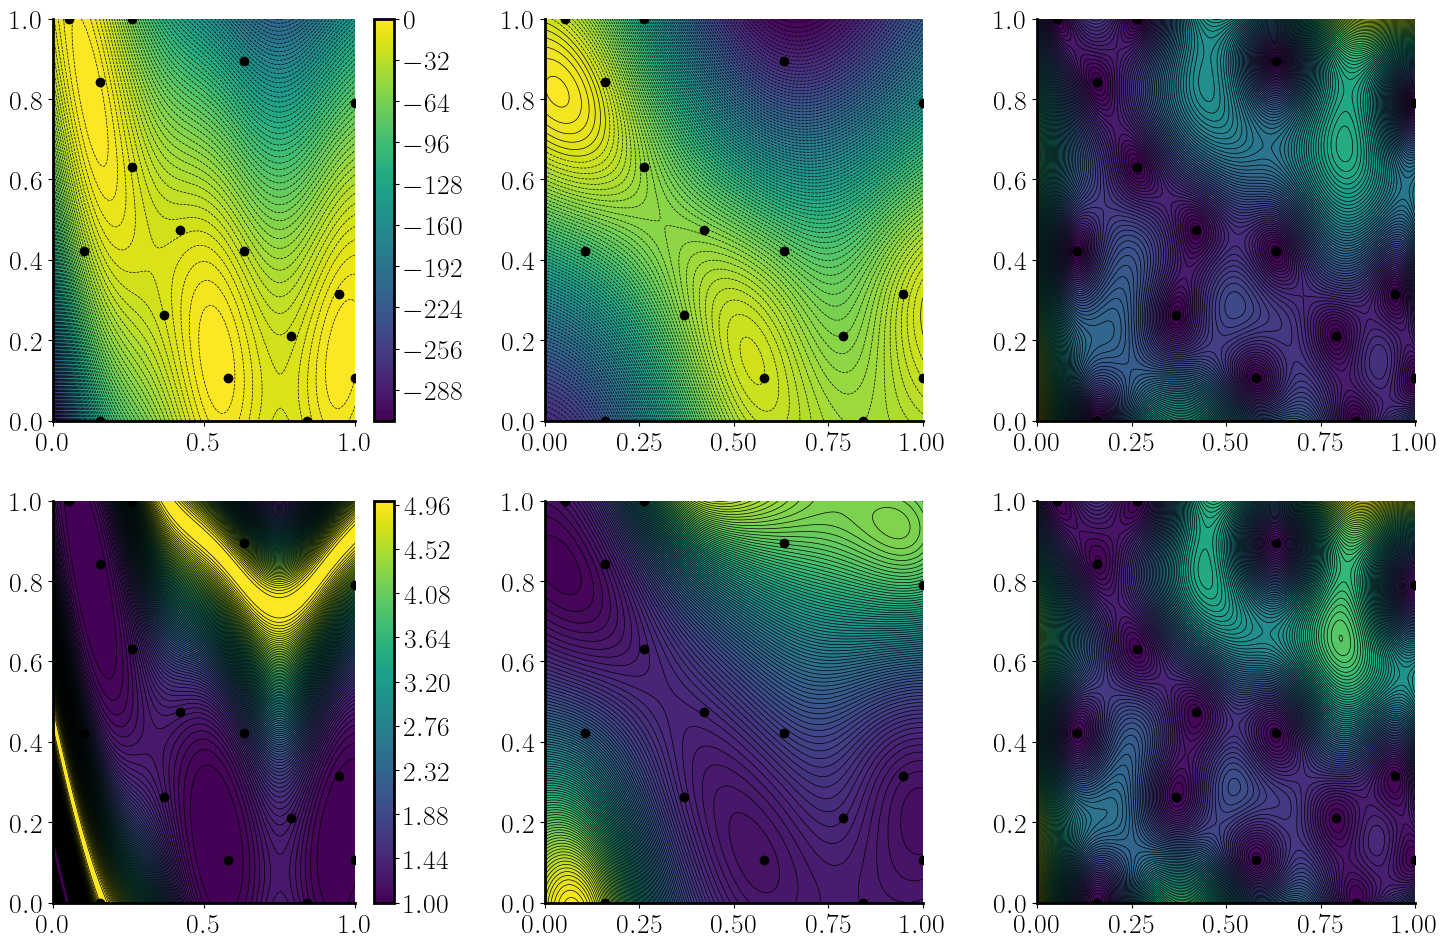

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for j in range(len(plots)):
    for i in range(len(plot)):
        cs = axes[j, i].contourf(xv,yv,plots[j][i],100)
        if not i:
            plt.colorbar(cs, ax=axes[j, 0])
        axes[j, i].contour(cs,colors='black', linewidths=.5)
        axes[j, i].scatter(data["train_X"][:, 0], data["train_X"][:, 1], color='black', zorder=100)
fig.tight_layout()
plt.show()

In [7]:
import torch
from botorch.acquisition.acquisition import AcquisitionFunction
from torch import Tensor

class CostWeightedAcquisitionFunction(AcquisitionFunction):
    r"""Single-outcome acquisition function divided by cost."""

    def __init__(
        self,
        raw_acqf: AcquisitionFunction,
        cost: torch.nn.Module,
        taus
    ) -> None:
        r"""Initializing cost-weighted acqf.

        Args:
            raw_acqf: The raw acquisition function that is going to be regularized.
            cost: A cost model
        """
        super().__init__(model=raw_acqf.model)
        self.raw_acqf = raw_acqf
        self.cost = cost
        tau, tau_k, tau_init = taus
        self.alpha = (tau - tau_k) / (tau - tau_init)

    def forward(self, X: Tensor) -> Tensor:
        raw_value = self.raw_acqf(X=X)
        cost_term = torch.exp(self.cost(X).mean).squeeze()
        return raw_value / cost_term**self.alpha

In [8]:
##### BO LOOP
data["bestval"] = torch.tensor([data["train_Y"].max()])
tau_init = data['costs'].sum()
remaining_budget = B  - tau_init
bounds = torch.cat((torch.zeros(1, dim), torch.ones(1, dim)))
while remaining_budget > 0:
    print(remaining_budget)
    af = pick_acqf(acqf, data, gpr, bounds)
    taus = [B, data['costs'].sum(), tau_init]
    costaf = CostWeightedAcquisitionFunction(af, gpr_cost, taus)
    candidates, _ = optimize_acqf(
                            acq_function=costaf, 
                            bounds=bounds,
                            q=1, # batch size, i.e. we only query one point
                            num_restarts=10,
                            raw_samples=512,
                            )
    y = embed_test_function(problem, candidates)
    c = black_box_cost(problem, candidates)
    data["train_X"] = torch.cat((data["train_X"], candidates))
    data["train_Y"] = torch.cat((data["train_Y"], y.view(-1, 1)))
    data["costs"] = torch.cat((data["costs"], c.view(-1, 1)))
    data["bestval"] = torch.cat((data["bestval"], (data["train_Y"].max()).unsqueeze(-1)))

    K = pick_kernel(ker, dim)                           
    gpr = SingleTaskGP(data["train_X"], data["train_Y"], covar_module=K)
    mll = ExactMarginalLogLikelihood(gpr.likelihood, gpr)
    fit_gpytorch_model(mll, max_retries=10);

    K = pick_kernel(ker, dim)                           
    gpr_cost = SingleTaskGP(data["train_X"], torch.log(data["costs"]), covar_module=K)
    mll_cost = ExactMarginalLogLikelihood(gpr_cost.likelihood, gpr_cost)
    fit_gpytorch_model(mll_cost, max_retries=20);
    remaining_budget -= float(c)

tensor(48.0092)
tensor(46.5004)
tensor(45.4984)
tensor(44.4982)
tensor(43.4980)
tensor(42.4978)
tensor(41.4965)
tensor(40.4946)
tensor(39.4932)
tensor(38.4922)
tensor(37.4917)
tensor(36.4916)
tensor(35.4905)
tensor(34.4901)
tensor(33.4890)
tensor(32.4887)
tensor(31.4875)
tensor(30.4871)
tensor(29.4867)
tensor(28.4863)
tensor(27.4861)
tensor(26.4859)
tensor(25.4858)
tensor(24.4857)
tensor(23.4856)
tensor(22.4855)
tensor(21.4854)
tensor(20.4852)
tensor(19.4845)
tensor(18.4843)
tensor(17.4842)
tensor(16.4841)
tensor(15.4840)
tensor(14.4839)
tensor(13.4838)
tensor(12.4836)
tensor(11.4835)
tensor(10.4834)
tensor(9.4820)
tensor(8.4819)
tensor(7.4818)
tensor(6.4817)
tensor(5.4797)
tensor(4.4796)
tensor(3.4794)
tensor(2.4793)
tensor(1.4786)
tensor(0.4785)


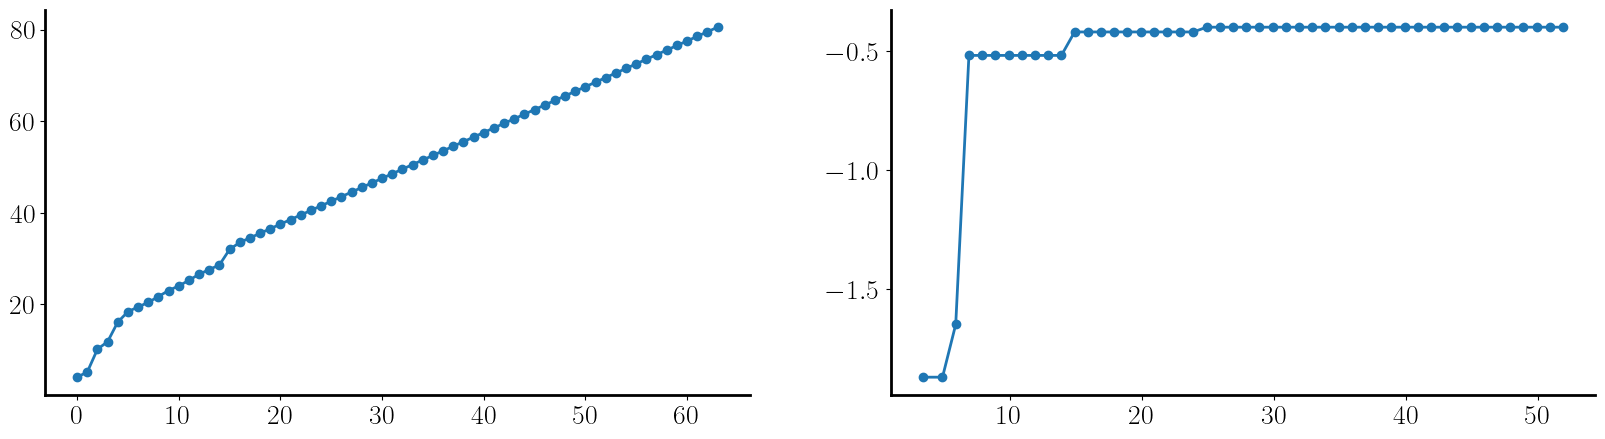

In [9]:
fig, axes = plt.subplots(1, 2,  figsize=(20,5))
axes[0].plot(range(len(data["costs"])), data["costs"].cumsum(dim=0), marker='o')
axes[1].plot(data["costs"][n_init -1:].cumsum(dim=0), data["bestval"], marker='o')
plt.show()